# Endogenous model shifts

In [1645]:
using CSV;
using DataFrames;
using LinearAlgebra;
using Distributions;
include("../julia/utils.jl");

## Synthetic data

### Single run

#### Fitting the Bayesian classifier

In [1646]:
include("../julia/bayes_logreg.jl");
include("../julia/optimization.jl");

In [1647]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall)).

In [1648]:
using RCall
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [1649]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);

In [1650]:
model = bayes_logreg(X,y);
w = model.μ;

In [1651]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];

In [1652]:
y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
estimates = DataFrame(hcat(y_probit,W), :auto);
features = copy(df);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

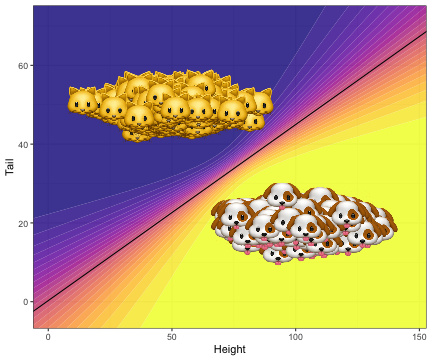

RObject{VecSxp}


In [1653]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=1-w[1], slope=-w[2]/w[3]) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    theme_bw() # |>
    # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)

#### Generating recourse

In [1654]:
include("../julia/gradients.jl");
include("../julia/generate_recourse.jl");

In [1655]:
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=());
df_counterfactual = [copy(df) for i in 1:length(generators)];
for j in 1:length(generators)
    insertcols!(df_counterfactual[j], :type => String(keys(generators)[j]))
end

In [1656]:
proportion = 0.2
using StatsBase
cats = findall(df.y.==0);
unhappy_cats = StatsBase.sample(cats,Int(round(proportion * length(cats))),replace=false);
X_f = [[df.x1[i], df.x2[i]] for i in unhappy_cats];

In [1657]:
counterfactuals = DataFrame();
for i in unhappy_cats
    x_f = [df.x1[i], df.x2[i]]
    for j in 1:length(generators)
        recourse_name = keys(generators)[j]
        recourse = generators[j](x_f,gradient,model,1;generator_args[j]...)
        y_hat = predict(model, reshape(vcat(1,recourse.x_cf),(1,length(recourse.x_cf)+1)))[1]
        # Update large data frame:
        df_counterfactual[j].y[i] = y_hat
        df_counterfactual[j].x1[i] = recourse.x_cf[1]
        df_counterfactual[j].x2[i] = recourse.x_cf[2]
        # Append small data frame:
        cf = DataFrame(reshape(recourse.x_cf,(1,length(recourse.x_cf))),:auto)
        insertcols!(cf, :type => String(recourse_name))
        insertcols!(cf, :emoji=> ifelse(y_hat==1,"../www/dog.png","../www/cat.png"))
        counterfactuals = vcat(counterfactuals, cf)
    end
end

In [1658]:
using Images, FileIO

In [1659]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=(1-w[1])/w[3], slope=-w[2]/w[3]) +
    geom_image(
        data=features[setdiff(1:size(features)[1],unhappy_cats),:], 
        aes(x=:x1, y=:x2, image=:emoji), 
        size=0.1, 
        image_fun=R"function(img) magick::image_fx(img, expression = '0.5*a', channel = 'alpha')"
    ) +
    geom_image(data=counterfactuals, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/endogenouse_shifts.png", plot = p, width=8, height=4);

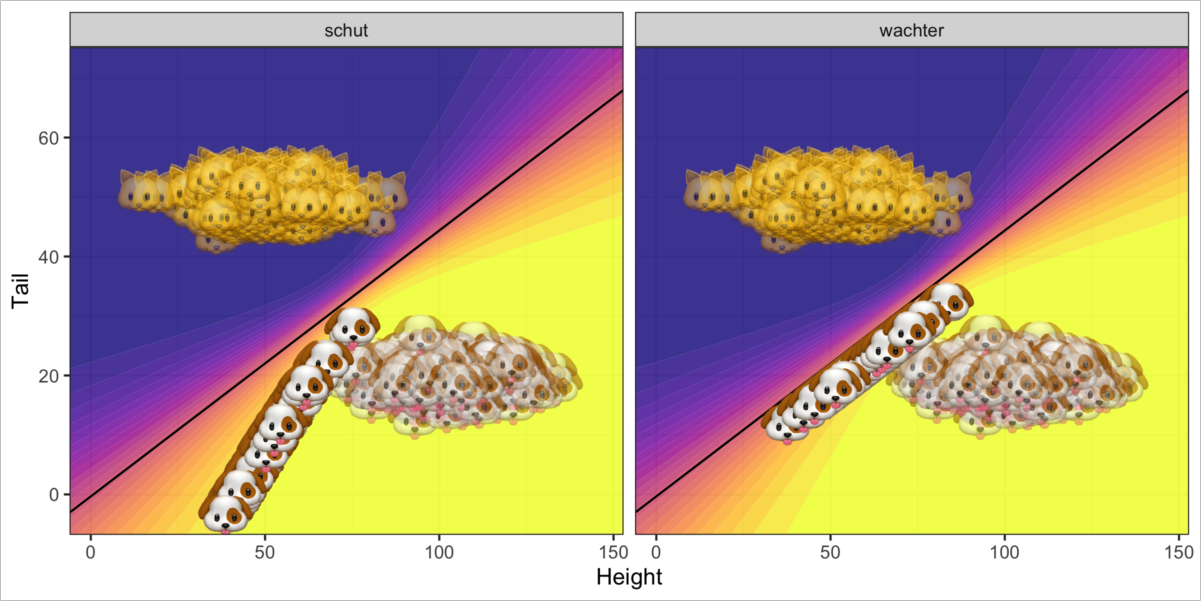

In [1660]:
load("www/endogenouse_shifts.png")

#### Retraining classifier

In [1661]:
estimates = DataFrame()
coefficients = DataFrame()
for j in 1:length(df_counterfactual)
    df_cf = df_counterfactual[j]
    recourse_name = String(keys(generators)[j])
    y = df_cf[:,:y];
    X = Matrix(df_cf[:,[:x1,:x2]]);
    model = bayes_logreg(X,y);
    coefficients_ = DataFrame(reshape(model.μ,(1,length(model.μ))), "w" .* string.(1:length(model.μ)))
    insertcols!(coefficients_, :const => 1-model.μ[1]/model.μ[3])
    insertcols!(coefficients_, :slope => -model.μ[2]/model.μ[3])
    insertcols!(coefficients_, :type => recourse_name)
    coefficients = vcat(coefficients,coefficients_);
    # Predictive posterior:
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    estimates_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(estimates_, :type => recourse_name)
    estimates = vcat(estimates, estimates_)
end

In [1662]:
features = reduce(vcat, df_counterfactual);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [1663]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=coefficients, aes(intercept=:const, slope=:slope)) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/post_shift.png", plot = p, width=8, height=4);

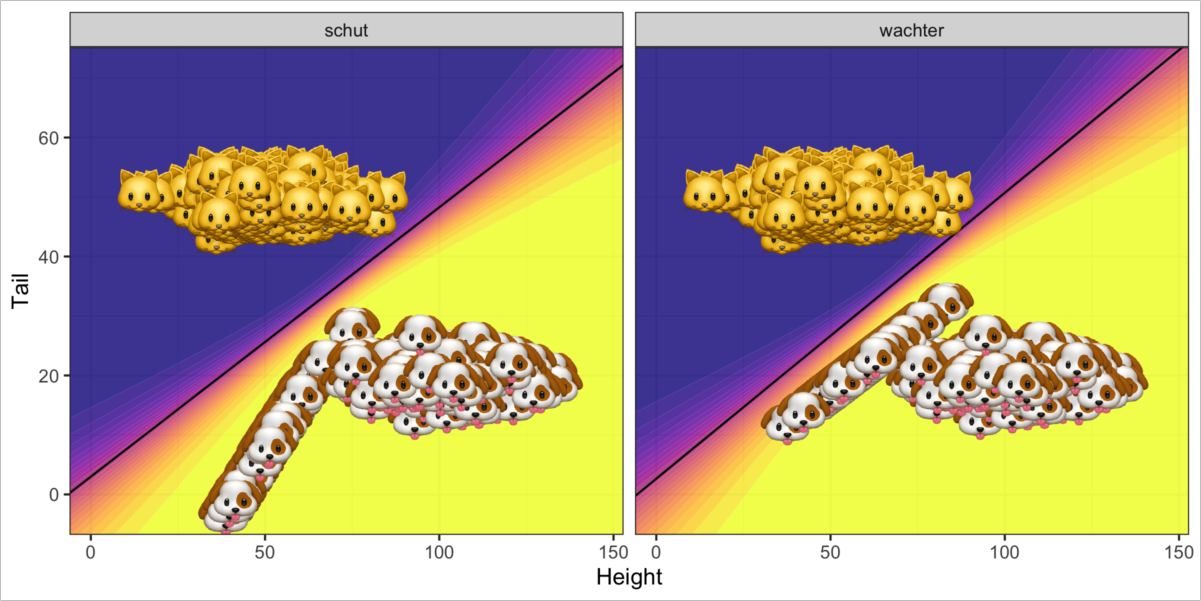

In [1664]:
load("www/post_shift.png")

### Single run with holdout

The experimental setup in this section is adapted from Upadhyay et al. (2021):

1. Train classifier ($\mathcal{M}_1$) on 4 folds of data $\mathcal{D}$ (training data).
2. Provide and implement recourse to $\mu$% of the training data. 
3. Retrain the classifier ($\mathcal{M}_2$) on training data with counterfactual labels.
4. Provide recourse to 5th fold (holdout data).
5. Check validity of recourse provided in 2.

This procedure is repeated for $K$ folds.

In [1665]:
function experiment_holdout(X,y,classifier,target,generator,generator_args;gradient=gradient,proportion_training=0.5,proportion_holdout=1.0,n_folds=5)
    # Setup:
    N = length(y);
    D = size(X)[2]; # number of features
    train_indices, test_indices = kfolds_(N;k=n_folds)
    avg_cost = zeros(0)
    pct_valid = zeros(0)
    recourse_path = DataFrame()
    clf_path = []
    
    for k in 1:n_folds
        # 0. Fold setup:
        train_rows = train_indices[k]
        test_rows = test_indices[k]
        X_train, y_train = (X[train_rows,:], y[train_rows])
        X_test, y_test = (X[test_rows,:], y[test_rows])
        
        # 1. Train (M1):
        M1 = classifier(X_train,y_train);

        # 2. Recourse on training:
        examples = findall(y_train.!=target);
        eligible_examples = StatsBase.sample(examples,Int(round(proportion_training * length(examples))),replace=false);
        X_train_cf = copy(X_train)
        y_train_cf = copy(y_train)
        for i in eligible_examples
            x_f = X_train_cf[i,:]
            recourse = generator(x_f,gradient,M1,1;generator_args...)
            X_train_cf[i,:] = recourse.x_cf 
            y_train_cf[i] = recourse.y_cf
        end

        # 3. Retrain (M2):
        M2 = classifier(X_train_cf,y_train_cf);

        # 4. Recourse for holdout:
        examples = findall(y_test.==0);
        eligible_examples = StatsBase.sample(examples,Int(round(proportion_holdout * length(examples))),replace=false);
        X_test_cf = copy(X_test)
        y_test_cf = copy(y_test)
        avg_cost_k = 0
        pct_valid_k = 0
        N_eligible = length(eligible_examples)
        for i in eligible_examples
            # Implement recourse
            x_f = X_test_cf[i,:]
            recourse = generator(x_f,gradient,M1,1;generator_args...) # recourse against M1
            X_test_cf[i,:] = recourse.x_cf 
            y_test_cf[i] = predict(M2, vcat(1, recourse.x_cf); proba=false)[1] # label according to M2
            # Validity and cost
            avg_cost_k += recourse.cost/N_eligible
            pct_valid_k += valid(recourse; classifier=M2)/N_eligible
        end
        
        # 5. Collect output:
        pct_valid_k = round(pct_valid_k; digits=5);
        avg_cost = vcat(avg_cost,avg_cost_k)
        pct_valid = vcat(pct_valid,pct_valid_k)
    end
    
    # Output:
    evaluation = DataFrame(hcat(pct_valid, avg_cost),[:validity, :cost])
    insertcols!(evaluation, :period => 1)
    insertcols!(evaluation, :fold => 1:n_folds)
    
    recourse_path = nothing
    clf_path = nothing
    
    return evaluation, recourse_path, clf_path
end;

In [1666]:
function run_experiment(X,y,classifier,target,generators,generator_args,experiment)
    evaluation = DataFrame()
    recourse_path = DataFrame()
    for i in 1:length(generators)
        generator_name = string(keys(generators)[i])
        evaluation_i, recourse_path_i, clf_path_i = experiment(X,y,classifier,target,generators[i],generator_args[i])
        insertcols!(evaluation_i, :generator => generator_name)
        evaluation = vcat(evaluation, evaluation_i)
    end
    return evaluation
end;

In [1667]:
run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_holdout)

,validity,cost,period,fold,generator
,Float64,Float64,Int64,Int64,String
1,1.0,26.6877,1,1,wachter
2,1.0,27.8259,1,2,wachter
3,1.0,27.2917,1,3,wachter
4,1.0,27.7711,1,4,wachter
5,1.0,27.0562,1,5,wachter
6,1.0,32.7723,1,1,schut
7,1.0,33.5798,1,2,schut
8,1.0,34.1889,1,3,schut
9,1.0,31.8387,1,4,schut


### Dynamic

In [1668]:
function experiment_dynamic(X,y,classifier,target,generator,generator_args;gradient=gradient,proportion_recourse=0.01,n_folds=1,n_rounds=10)
    # Setup:
    N = length(y);
    D = size(X)[2] # number of features
    
    # Allocating memory:
    recourse_path = DataFrame()
    clf_path = []
    results = DataFrame(idx=1:N, received_recourse=false, label=y, validity=1.0, cost=0.0)
    X_train = copy(X)
    y_train = copy(y)
    avg_cost = zeros(0)
    pct_valid = zeros(0)
    
    # Recursion:
    t = 1
    while t<=n_rounds
        # Train classifier:
        model = classifier(X_train,y_train) # might want to use w_t-1 as new prior
        clf_path = vcat(clf_path, model)
        w = model.μ
        # w_0 = w # posterior as new prior
        # H_0 = model.Σ
        
        # Provide recourse:
        undesired = findall(y_train.!=target)
        N_0 = length(undesired)
        recourse_eligible = StatsBase.sample(undesired,Int(round(proportion_recourse * N_0)),replace=false)
        avg_cost_k = 0
        pct_valid_k = 0
        for i in recourse_eligible
            # Implement recourse:
            x_f = X_train[i,:]
            recourse = generator(x_f,gradient,model,target;generator_args...)
            X_train[i,:] = recourse.x_cf
            idx = findall(results.idx .== i)[1]
            results[idx,:received_recourse] = true
            results[idx,:cost] = recourse.cost
        end
        y_train = predict(model, X_train)
        results.label .= y_train
        results.validity .= results.label .== target 
        recourse_outcome = DataFrame(hcat(y_train,X_train), vcat("y", "x" .* string.(1:D)))
        insertcols!(recourse_outcome, :period => t)
        recourse_path = vcat(recourse_path, recourse_outcome)
        
        # Validity and cost
        avg_cost_t = mean(results[(results.received_recourse),:].cost)
        pct_valid_t = mean(results[(results.received_recourse),:].validity)
        avg_cost = vcat(avg_cost,avg_cost_t)
        pct_valid = vcat(pct_valid,pct_valid_t)
        
        # Updates:
        t += 1
    end
    
    
    # Output:
    evaluation = DataFrame(hcat(pct_valid, avg_cost),[:validity, :cost])
    insertcols!(evaluation, :period => 1:n_rounds)
    insertcols!(evaluation, :fold => 1)
    
    return evaluation, recourse_path, clf_path
end;

In [1669]:
props = [0.01,0.05,0.1,0.25]
results = DataFrame()
for prop in props
    results_prop = run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_dynamic)
    insertcols!(results_prop, :prop => prop)
    results = vcat(results, results_prop)
end

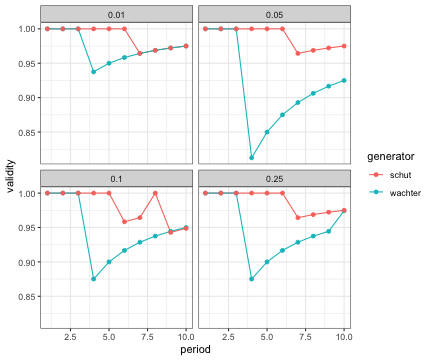

RObject{VecSxp}


In [1670]:
ggplot(data=results, aes(x=:period, y=:validity, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 

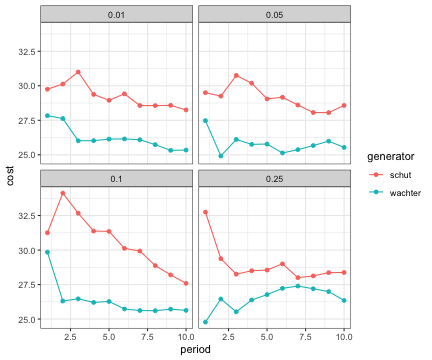

RObject{VecSxp}


In [1671]:
ggplot(data=results, aes(x=:period, y=:cost, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 

#### Wachter et al.

In [1672]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
evaluation, recourse_path, clf_path = experiment_dynamic(X,y,bayes_logreg,target,generators[1],generator_args[1]);

In [1673]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [1674]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_wachter.png", plot = p, width=8, height=2/(n_rounds/2)*8);

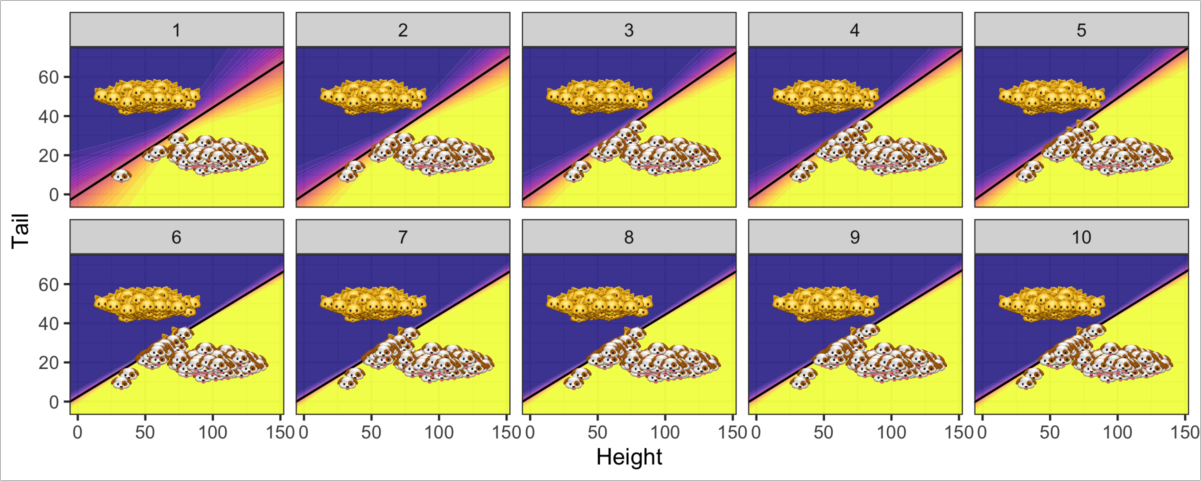

In [1675]:
load("www/dynamic_wachter.png")

#### Schut et al.

In [1676]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
evaluation, recourse_path, clf_path = experiment_dynamic(X,y,bayes_logreg,target,generators[2],generator_args[2]);

In [1677]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [1678]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_schut.png", plot = p, width=8, height=2/(n_rounds/2)*8);

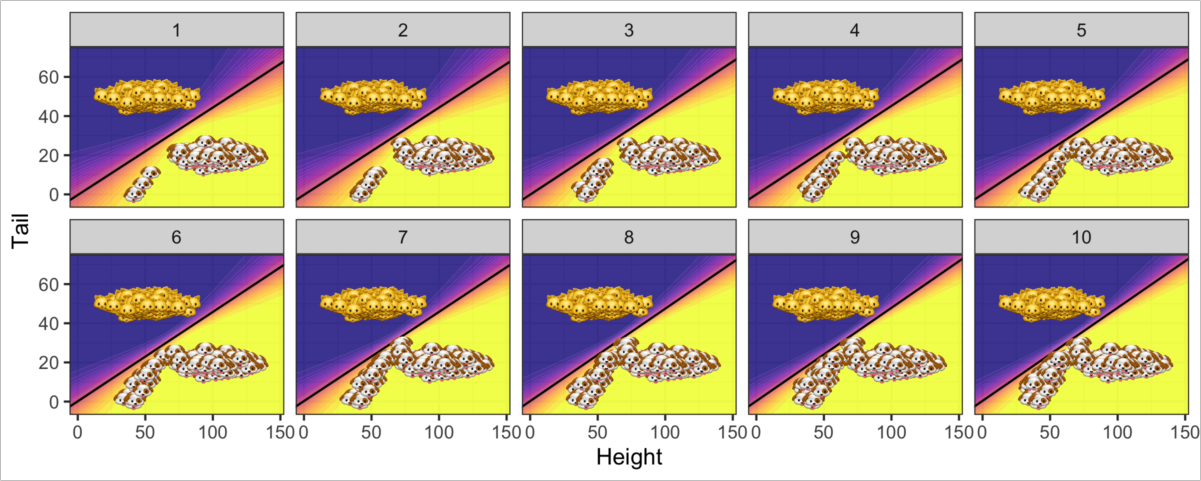

In [1679]:
load("www/dynamic_schut.png")

## German credit data

### Quick run

In [1680]:
df = CSV.read("../data/credit.csv", DataFrame);
df[!,:] = convert.(Float64, df[!,:]); # convert to floats

In [1681]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
model = bayes_logreg(X,y);
w = model.μ;

In [1682]:
x = X[rand(findall(y.==0)),:]
generate_recourse_schut(x,gradient,model,1;n=50)

Recourse([36.0, 3915.0, 27.0, 0.0, 0.0, 51.0, 49.0], 1.0, [36.0 3915.0 … 1.0 0.0; 36.0 3915.0 … 2.0 0.0; … ; 36.0 3915.0 … 51.0 48.0; 36.0 3915.0 … 51.0 49.0], 1.0, true, 70.00714249274856, [36.0, 3915.0, 27.0, 0.0, 0.0, 1.0, 0.0])

In [1683]:
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=(T=1000,δ=0.05));

In [1684]:
props = [0.01,0.05,0.1,0.25]
results = DataFrame()
for prop in props
    results_prop = run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_dynamic)
    insertcols!(results_prop, :prop => prop)
    results = vcat(results, results_prop)
end

Possible that these results are driven by the following fact:

- classifier is biased towards target class (try random over/undersampling)

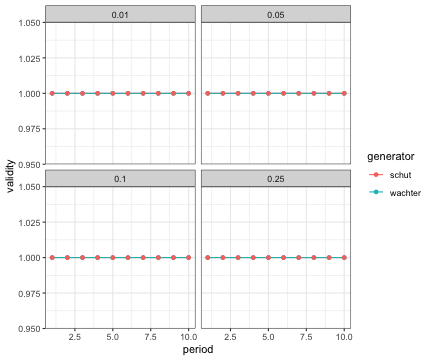

RObject{VecSxp}


In [1685]:
ggplot(data=results, aes(x=:period, y=:validity, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 

Interesting to see that there are some clear trends in the cost of recourse over time:

- what could be the reason for these dynamics?

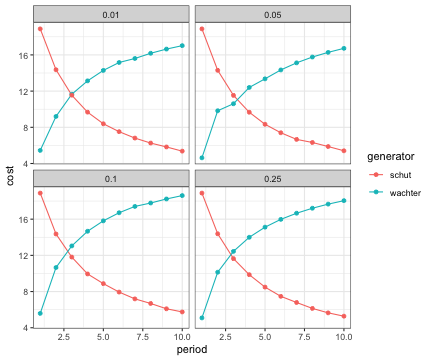

RObject{VecSxp}


In [1686]:
ggplot(data=results, aes(x=:period, y=:cost, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 

In [1687]:
props = [0.01,0.05,0.1,0.25]
results = DataFrame()
for prop in props
    results_prop = run_experiment(X,y,bayes_logreg,0,generators,generator_args,experiment_dynamic)
    insertcols!(results_prop, :prop => prop)
    results = vcat(results, results_prop)
end

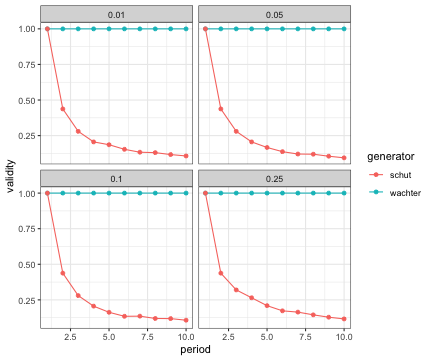

RObject{VecSxp}


In [1688]:
ggplot(data=results, aes(x=:period, y=:validity, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 

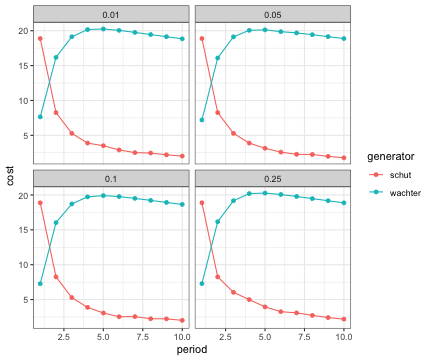

RObject{VecSxp}


In [1689]:
ggplot(data=results, aes(x=:period, y=:cost, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 

### Adjusting for imbalance

┌ Warning: The closest lower feasible false positive rate to some of the required values (0.0033444816053511705, 0.006688963210702341, 0.010033444816053512, 0.013377926421404682, 0.016722408026755852, 0.020066889632107024, 0.023411371237458192, 0.026755852842809364, 0.030100334448160536, 0.033444816053511704, 0.03678929765886288, 0.04013377926421405, 0.043478260869565216, 0.046822742474916385, 0.05016722408026756, 0.05351170568561873, 0.056856187290969896, 0.06020066889632107, 0.06354515050167224, 0.06688963210702341, 0.07023411371237458, 0.07357859531772576, 0.07692307692307693, 0.0802675585284281, 0.08361204013377926, 0.08695652173913043, 0.0903010033444816, 0.09364548494983277, 0.09698996655518395, 0.10033444816053512, 0.10367892976588629, 0.10702341137123746, 0.11036789297658862, 0.11371237458193979, 0.11705685618729098, 0.12040133779264214, 0.12374581939799331, 0.12709030100334448, 0.13043478260869565, 0.13377926421404682, 0.13712374581939799, 0.14046822742474915, 0.14381270903010

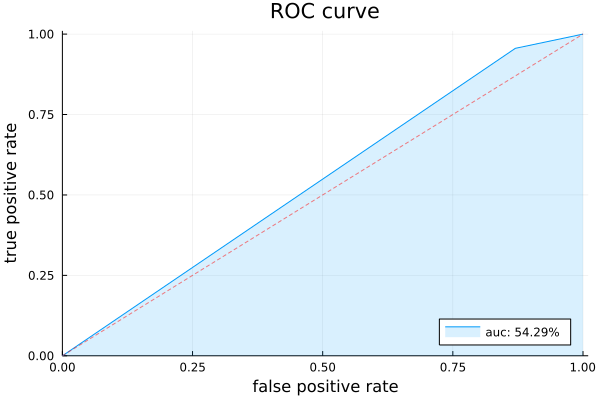

In [1690]:
using EvalMetrics
using Plots
y_hat = predict(model,X)
rocplot(y,y_hat)

In [1691]:
using MLDataUtils
X_train, y_train = oversample((transpose(X),y))
X_train = transpose(X_train);

In [1692]:
props = [0.01,0.05,0.1,0.25]
results = DataFrame()
for prop in props
    results_prop = run_experiment(X_train,y_train,bayes_logreg,target,generators,generator_args,experiment_dynamic)
    insertcols!(results_prop, :prop => prop)
    results = vcat(results, results_prop)
end

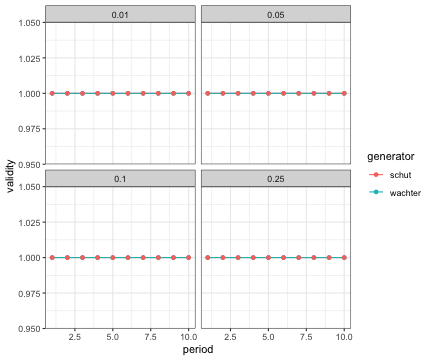

RObject{VecSxp}


In [1693]:
ggplot(data=results, aes(x=:period, y=:validity, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 

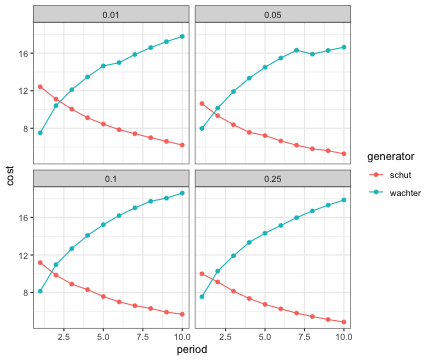

RObject{VecSxp}


In [1694]:
ggplot(data=results, aes(x=:period, y=:cost, colour=:generator)) +
    geom_line() + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() 